In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

In [ ]:

def drop_path(x, drop_prob: float = 0., training: bool = False):
    """
    Drop paths (Stochastic Depth) per sample (gdy jest używane w forward bloku).
    """
    if drop_prob == 0. or not training:
        return x
    keep_prob = 1 - drop_prob
    # Obliczenie maski (B, 1, 1, ...) dla losowego pomijania
    shape = (x.shape[0],) + (1,) * (x.ndim - 1)
    random_tensor = keep_prob + torch.rand(shape, dtype=x.dtype, device=x.device)
    mask = random_tensor.floor().div(keep_prob)
    return x * mask

class DropPath(nn.Module):
    """
    Moduł DropPath, używający funkcji drop_path.
    """
    def __init__(self, drop_prob=None):
        super(DropPath, self).__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        return drop_path(x, self.drop_prob, self.training)

class PatchEmbed(nn.Module):
    def __init__(self, img_size, patch_size, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2)
        x = x.transpose(1, 2)
        return x

class Attention(nn.Module):
    def __init__(self, dim, num_heads=12, qkv_bias=False):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.proj = nn.Linear(dim, dim)

    def forward(self, x):
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x

class Block(nn.Module):
    def __init__(self, dim, num_heads, mlp_ratio=4., qkv_bias=False, norm_layer=nn.LayerNorm, drop_path_rate=0.0):
        super().__init__()
        self.norm1 = norm_layer(dim)
        self.attn = Attention(dim, num_heads=num_heads, qkv_bias=qkv_bias)
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Linear(mlp_hidden_dim, dim)
        )
        self.drop_path = DropPath(drop_path_rate) if drop_path_rate > 0. else nn.Identity()

    def forward(self, x):
        x = x + self.drop_path(self.attn(self.norm1(x)))
        x = x + self.drop_path(self.mlp(self.norm2(x)))
        return x

class VisionTransformer(nn.Module):
    def __init__(self, img_size=32, patch_size=4, in_channels=3, num_classes=10,
                 embed_dim=192, depth=12, num_heads=3, mlp_ratio=4, drop_path_rate=0.1):
        super().__init__()

        self.patch_embed = PatchEmbed(img_size=img_size, patch_size=patch_size,
                                      in_channels=in_channels, embed_dim=embed_dim)

        n_patches = self.patch_embed.n_patches

        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.pos_drop = nn.Dropout(p=0.1)

        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, depth)]

        self.blocks = nn.ModuleList([
            Block(
                dim=embed_dim,
                num_heads=num_heads,
                mlp_ratio=mlp_ratio,
                drop_path_rate=dpr[i]
            )
            for i in range(depth)
        ])
        self.norm = nn.LayerNorm(embed_dim)

        self.head = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        B = x.shape[0]

        x = self.patch_embed(x)
        cls_token = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_token, x), dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)

        for blk in self.blocks:
            x = blk(x)

        x = self.norm(x)

        cls_token_output = x[:, 0]
        x = self.head(cls_token_output)

        return x


model = VisionTransformer(
    img_size=32,
    patch_size=4,
    num_classes=10,
    embed_dim=384,
    depth=12,
    num_heads=6,
    drop_path_rate=0.2
)

In [ ]:
mean = [0.4914, 0.4822, 0.4465]
std = [0.2470, 0.2435, 0.2616]
BATCH_SIZE = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=3),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
    transforms.RandomErasing(p=0.25),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
model = VisionTransformer(num_classes=10)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.05)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=300)
criterion = nn.CrossEntropyLoss()

In [ ]:
num_epochs = 50
best_acc = 70

train_acc_list = []
test_acc_list = []
loss_list = []

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for inputs, labels in tqdm(train_loader, desc=f"Epoka {epoch+1}/{num_epochs}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100.*correct/total
    epoch_loss = running_loss / len(train_loader)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_acc = 100.*correct/total

    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    loss_list.append(epoch_loss)

    if test_acc > best_acc:
      best_acc = test_acc
      torch.save(model.state_dict(), f"ViT_epoch_{epoch+1}.pth")

    scheduler.step()

    print(f"Epoka {epoch+1}/{num_epochs} – Loss: {epoch_loss:.3f} – Train Acc: {train_acc:.2f}% – Test Acc: {test_acc:.2f}%")

Epoka 1/50: 100%|██████████| 391/391 [01:33<00:00,  4.19it/s]


Epoka 1/50 – Loss: 1.850 – Train Acc: 30.51% – Test Acc: 36.22%


Epoka 2/50: 100%|██████████| 391/391 [01:33<00:00,  4.17it/s]


Epoka 2/50 – Loss: 1.588 – Train Acc: 41.58% – Test Acc: 42.38%


Epoka 3/50: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]


Epoka 3/50 – Loss: 1.440 – Train Acc: 47.52% – Test Acc: 49.87%


Epoka 4/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 4/50 – Loss: 1.351 – Train Acc: 50.78% – Test Acc: 55.22%


Epoka 5/50: 100%|██████████| 391/391 [01:30<00:00,  4.33it/s]


Epoka 5/50 – Loss: 1.280 – Train Acc: 53.38% – Test Acc: 58.17%


Epoka 6/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 6/50 – Loss: 1.224 – Train Acc: 55.66% – Test Acc: 60.49%


Epoka 7/50: 100%|██████████| 391/391 [01:30<00:00,  4.33it/s]


Epoka 7/50 – Loss: 1.173 – Train Acc: 57.81% – Test Acc: 61.51%


Epoka 8/50: 100%|██████████| 391/391 [01:30<00:00,  4.32it/s]


Epoka 8/50 – Loss: 1.124 – Train Acc: 59.69% – Test Acc: 63.62%


Epoka 9/50: 100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


Epoka 9/50 – Loss: 1.085 – Train Acc: 61.16% – Test Acc: 65.46%


Epoka 10/50: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


Epoka 10/50 – Loss: 1.053 – Train Acc: 62.28% – Test Acc: 65.73%


Epoka 11/50: 100%|██████████| 391/391 [01:31<00:00,  4.25it/s]


Epoka 11/50 – Loss: 1.020 – Train Acc: 63.55% – Test Acc: 67.03%


Epoka 12/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 12/50 – Loss: 0.986 – Train Acc: 64.85% – Test Acc: 67.86%


Epoka 13/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 13/50 – Loss: 0.966 – Train Acc: 65.83% – Test Acc: 69.02%


Epoka 14/50: 100%|██████████| 391/391 [01:30<00:00,  4.33it/s]


Epoka 14/50 – Loss: 0.940 – Train Acc: 67.04% – Test Acc: 68.16%


Epoka 15/50: 100%|██████████| 391/391 [01:30<00:00,  4.32it/s]


Epoka 15/50 – Loss: 0.921 – Train Acc: 67.25% – Test Acc: 71.89%


Epoka 16/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 16/50 – Loss: 0.883 – Train Acc: 68.67% – Test Acc: 72.43%


Epoka 17/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 17/50 – Loss: 0.866 – Train Acc: 69.21% – Test Acc: 72.94%


Epoka 18/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 18/50 – Loss: 0.848 – Train Acc: 70.05% – Test Acc: 72.19%


Epoka 19/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 19/50 – Loss: 0.827 – Train Acc: 70.78% – Test Acc: 74.16%


Epoka 20/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 20/50 – Loss: 0.811 – Train Acc: 71.34% – Test Acc: 74.59%


Epoka 21/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 21/50 – Loss: 0.788 – Train Acc: 71.84% – Test Acc: 75.31%


Epoka 22/50: 100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


Epoka 22/50 – Loss: 0.769 – Train Acc: 72.63% – Test Acc: 74.33%


Epoka 23/50: 100%|██████████| 391/391 [01:31<00:00,  4.30it/s]


Epoka 23/50 – Loss: 0.761 – Train Acc: 72.90% – Test Acc: 76.30%


Epoka 24/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 24/50 – Loss: 0.741 – Train Acc: 73.79% – Test Acc: 74.16%


Epoka 25/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 25/50 – Loss: 0.729 – Train Acc: 74.25% – Test Acc: 75.61%


Epoka 26/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 26/50 – Loss: 0.706 – Train Acc: 74.93% – Test Acc: 76.09%


Epoka 27/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 27/50 – Loss: 0.697 – Train Acc: 75.24% – Test Acc: 75.86%


Epoka 28/50: 100%|██████████| 391/391 [01:30<00:00,  4.32it/s]


Epoka 28/50 – Loss: 0.677 – Train Acc: 76.09% – Test Acc: 77.32%


Epoka 29/50: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


Epoka 29/50 – Loss: 0.663 – Train Acc: 76.42% – Test Acc: 77.89%


Epoka 30/50: 100%|██████████| 391/391 [01:30<00:00,  4.33it/s]


Epoka 30/50 – Loss: 0.646 – Train Acc: 77.09% – Test Acc: 78.02%


Epoka 31/50: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


Epoka 31/50 – Loss: 0.634 – Train Acc: 77.43% – Test Acc: 77.07%


Epoka 32/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 32/50 – Loss: 0.620 – Train Acc: 77.97% – Test Acc: 77.66%


Epoka 33/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 33/50 – Loss: 0.607 – Train Acc: 78.31% – Test Acc: 78.02%


Epoka 34/50: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]


Epoka 34/50 – Loss: 0.591 – Train Acc: 79.06% – Test Acc: 78.37%


Epoka 35/50: 100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


Epoka 35/50 – Loss: 0.582 – Train Acc: 79.31% – Test Acc: 78.90%


Epoka 36/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 36/50 – Loss: 0.567 – Train Acc: 79.64% – Test Acc: 79.98%


Epoka 37/50: 100%|██████████| 391/391 [01:30<00:00,  4.30it/s]


Epoka 37/50 – Loss: 0.557 – Train Acc: 80.29% – Test Acc: 79.34%


Epoka 38/50: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]


Epoka 38/50 – Loss: 0.543 – Train Acc: 80.71% – Test Acc: 79.20%


Epoka 39/50: 100%|██████████| 391/391 [01:32<00:00,  4.24it/s]


Epoka 39/50 – Loss: 0.537 – Train Acc: 80.87% – Test Acc: 79.04%


Epoka 40/50: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]


Epoka 40/50 – Loss: 0.515 – Train Acc: 81.64% – Test Acc: 80.03%


Epoka 41/50: 100%|██████████| 391/391 [01:32<00:00,  4.24it/s]


Epoka 41/50 – Loss: 0.508 – Train Acc: 81.95% – Test Acc: 80.03%


Epoka 42/50: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoka 42/50 – Loss: 0.493 – Train Acc: 82.41% – Test Acc: 80.58%


Epoka 43/50: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]


Epoka 43/50 – Loss: 0.485 – Train Acc: 82.63% – Test Acc: 79.75%


Epoka 44/50: 100%|██████████| 391/391 [01:32<00:00,  4.24it/s]


Epoka 44/50 – Loss: 0.473 – Train Acc: 83.35% – Test Acc: 80.37%


Epoka 45/50: 100%|██████████| 391/391 [01:31<00:00,  4.26it/s]


Epoka 45/50 – Loss: 0.457 – Train Acc: 83.61% – Test Acc: 79.12%


Epoka 46/50: 100%|██████████| 391/391 [01:31<00:00,  4.28it/s]


Epoka 46/50 – Loss: 0.454 – Train Acc: 83.72% – Test Acc: 80.10%


Epoka 47/50: 100%|██████████| 391/391 [01:32<00:00,  4.23it/s]


Epoka 47/50 – Loss: 0.436 – Train Acc: 84.29% – Test Acc: 79.35%


Epoka 48/50: 100%|██████████| 391/391 [01:31<00:00,  4.27it/s]


Epoka 48/50 – Loss: 0.430 – Train Acc: 84.63% – Test Acc: 80.08%


Epoka 49/50: 100%|██████████| 391/391 [01:30<00:00,  4.31it/s]


Epoka 49/50 – Loss: 0.420 – Train Acc: 84.80% – Test Acc: 80.04%


Epoka 50/50: 100%|██████████| 391/391 [01:31<00:00,  4.29it/s]


Epoka 50/50 – Loss: 0.410 – Train Acc: 85.39% – Test Acc: 80.94%


# Wizualizacja wyników

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sn
import numpy as np

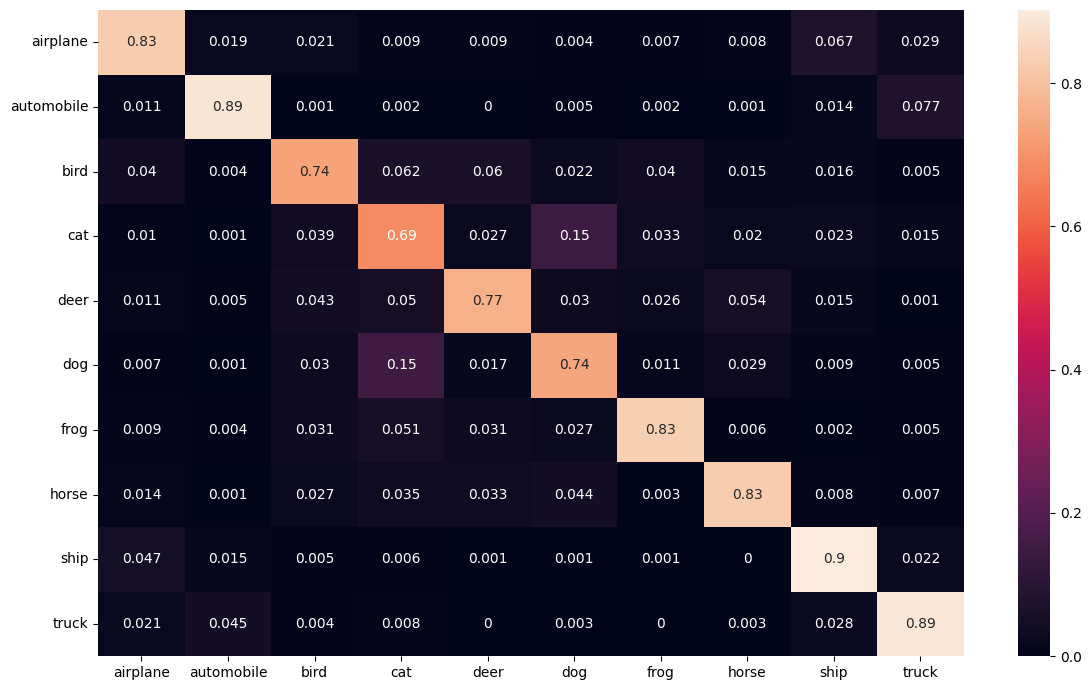

              precision    recall  f1-score   support

    airplane       0.83      0.83      0.83      1000
  automobile       0.90      0.89      0.90      1000
        bird       0.79      0.74      0.76      1000
         cat       0.65      0.69      0.67      1000
        deer       0.81      0.77      0.79      1000
         dog       0.72      0.74      0.73      1000
        frog       0.87      0.83      0.85      1000
       horse       0.86      0.83      0.84      1000
        ship       0.83      0.90      0.87      1000
       truck       0.84      0.89      0.86      1000

    accuracy                           0.81     10000
   macro avg       0.81      0.81      0.81     10000
weighted avg       0.81      0.81      0.81     10000



In [ ]:
predicted_labels = []
actual_labels = []
class_names = train_dataset.classes

model.eval()

with torch.no_grad():
  for images, labels in DataLoader(dataset=test_dataset, batch_size=1):
    images, labels = images.to(device), labels.to(device)
    prediction_logits = model(images)

    predictions = prediction_logits.argmax(dim=1).cpu().numpy()
    predicted_labels.extend(predictions)
    true_labels = labels.cpu().numpy()
    actual_labels.extend(true_labels)

confusion_mat = confusion_matrix(actual_labels, predicted_labels)
confusion_df = pd.DataFrame(confusion_mat/np.sum(confusion_mat)*10, index=class_names, columns=class_names)

plt.figure(figsize=(12,7))
sn.heatmap(confusion_df, annot=True)
plt.tight_layout()
plt.savefig(f"confusion_matrix_ViT.png")
plt.show()


report = classification_report(actual_labels, predicted_labels, target_names=class_names)
print(report)

with open("confusion_matrix_ViT.txt", "w") as f:
    f.write(report)

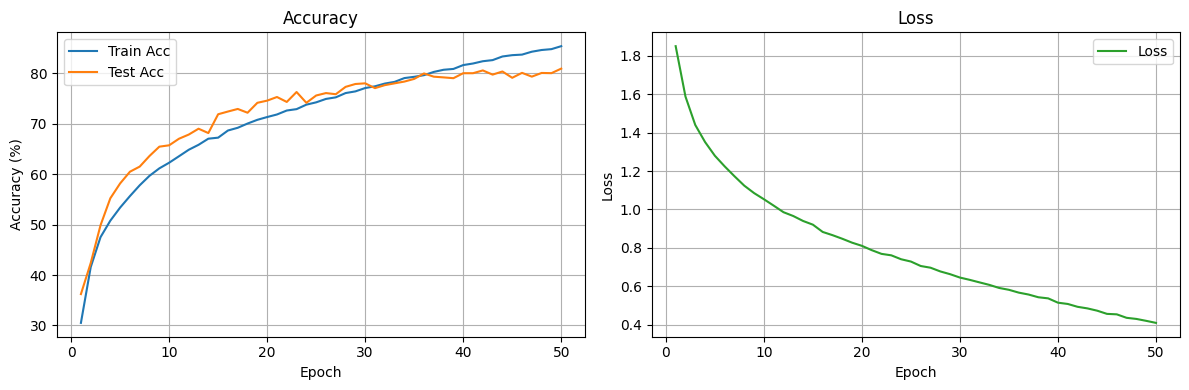

In [ ]:
epochs = range(1, len(train_acc_list) + 1)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(epochs, train_acc_list, label="Train Acc")
axes[0].plot(epochs, test_acc_list, label="Test Acc")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Accuracy (%)")
axes[0].set_title("Accuracy")
axes[0].legend()
axes[0].grid(True)

axes[1].plot(epochs, loss_list, label="Loss", color="C2")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Loss")
axes[1].set_title("Loss")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.savefig("ViT_wykresy.png")
plt.show()